## Differential Expression Analysis - RhithroLoxo

If you've already saved the workspace image from a previous session, jupyter should automatically reload it. You may need to reload the packages though. The .RData file is not on GitHub, so you will have to actually run it the first time through. 

First, make sure you're actually running this from a compute node, not the login. On Poseidon, logins are 'l1' and 'l2', whereas all other nodes start with 'pn'.

In [1]:
Sys.info()

sysname                               release 
                              "Linux"           "3.10.0-693.2.2.el7.x86_64" 
                              version                              nodename 
"#1 SMP Tue Sep 12 22:26:13 UTC 2017"                               "pn010" 
                              machine                                 login 
                             "x86_64"                             "unknown" 
                                 user                        effective_user 
                            "ztobias"                             "ztobias"

Now load in the packages.

In [2]:
require(DESeq2)
require(ggplot2)
require(apeglm)
require(ashr)
library("BiocParallel")
register(MulticoreParam(8))
require(VennDiagram)
require(RColorBrewer)
require(pheatmap)

Loading required package: DESeq2
Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Attaching p

Now import the count data, rounding decimals to integers.

In [3]:
path_to_main <- "/vortexfs1/scratch/ztobias/RhithroLoxo_DE/" #change accordingly based on parent file structure
path_to_counts <- "outputs/quant/salmon.isoform.counts.matrix"
path <- paste(path_to_main,path_to_counts,sep="")
all_counts <- read.table(path,header=TRUE)
all_counts <- round(all_counts)

Take a look.

In [4]:
head(all_counts)
dim(all_counts)

,AP_C_1,AP_C_2,AP_C_3,AP_C_4,AP_C_5,AP_C_6,AP_P_1,AP_P_2,AP_P_3,AP_P_6,...,NJ_P_7,SC_C_12,SC_C_14,SC_C_2,SC_C_6,SC_C_7,SC_C_9,SC_P_1,SC_P_2,SC_P_3
TRINITY_DN38930_c0_g1_i1,71,201,88,108,84,156,46,69,43,68,...,80,51,80,84,55,56,63,66,69,39
TRINITY_DN61353_c1_g1_i1,0,5,0,1,1,0,0,2,0,2,...,0,0,1,0,0,2,1,5,2,0
TRINITY_DN130836_c0_g1_i1,2,7,0,14,6,0,1,9,5,7,...,18,7,10,2,2,3,7,10,7,6
TRINITY_DN135735_c0_g1_i1,1,3,1,4,3,0,0,1,0,2,...,2,1,2,0,0,0,2,3,1,2
TRINITY_DN142305_c0_g1_i1,0,0,2,0,2,3,0,1,1,0,...,3,3,0,1,1,0,3,0,4,0
TRINITY_DN107975_c0_g1_i1,0,0,0,0,0,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


[1] 149511     83

Read in the sample metadata and have a look.

In [5]:
path_to_meta <- paste(path_to_main,"metadata/DESeq2_coldata.txt",sep="")
coldata <- read.table(path_to_meta,header=FALSE,row.names=1)
colnames(coldata) <- c("site","condition","range","sex")
head(coldata)
dim(coldata)

,site,condition,range,sex
AP_C_1,AP,C,Native,F
AP_C_2,AP,C,Native,F
AP_C_3,AP,C,Native,M
AP_C_4,AP,C,Native,M
AP_C_5,AP,C,Native,M
AP_C_6,AP,C,Native,M


[1] 83  4

Make sure the two matrices contain all of the same samples and are in order.

In [6]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay here I am just going to calculate the normalized counts so I can try to identify transcripts whose highest representation occurs in the Loxo libraries. This is because there appears to be some latent contamination, either from index hopping or basal levels infection in otherwise "uninfected" crabs. This shows up downstream in some crazily overexpressed transcripts in the parasitized individuals, which appear not to be an actual response, but rather just contamination with parasite mRNA. This might not help completely because of tissue specific expression in the parasite (libraries made from externae, while contamination from internal, root-system tissues), but worth a shot. At least to strengthen the case for removal by thresholding later. 

The infected crabs will be excluded from this comparison. Because of tissue specific expression in the parasite, the highest expression of some contaminant transcripts may be expected in the infected crab libraries rather than those of the parasite itself. Thus, we are just looking for transcripts that are more highly represented in the parasite libraries than the control crab libraries.

Create a DESeq dataset just for the purpose of calculating normalized counts

In [7]:
contam <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~ condition )

converting counts to integer mode


Estimate size factors and save normalized counts to object 'norm_mat'

In [8]:
contam <- estimateSizeFactors(contam)
norm_mat <- counts(contam, normalized=TRUE)

First let's remove the parasitized crabs. This includes all samples with the naming pattern `*_P_*`. The function `grepl()` returns a boolean vector that can be used to index. I will also remove sample MD_C_12, as this was identified to have a latent infection (unidentified infection detected in previous runs of this analysis).

In [9]:
norm_mat_sub <- norm_mat[,!grepl("*_P_*", colnames(norm_mat))]
norm_mat_sub <- subset(norm_mat_sub, select=-c(MD_C_12))

In [10]:
colnames(norm_mat_sub)

[1] "AP_C_1"  "AP_C_2"  "AP_C_3"  "AP_C_4"  "AP_C_5"  "AP_C_6"  "FP_C_10"
 [8] "FP_C_11" "FP_C_12" "FP_C_13" "FP_C_5"  "FP_C_9"  "LA_C_1"  "LA_C_2" 
[15] "LA_C_3"  "LA_C_4"  "LA_C_6"  "LA_C_8"  "LA_F_1"  "MA_C_1"  "MA_C_2" 
[22] "MA_C_4"  "MD_C_10" "MD_C_11" "MD_C_1"  "MD_C_4"  "MD_C_7"  "MD_F_4" 
[29] "ML_C_10" "ML_C_2"  "ML_C_3"  "ML_C_5"  "ML_C_7"  "ML_C_9"  "NH_C_11"
[36] "NH_C_12" "NH_C_13" "NH_C_5"  "NH_C_8"  "NH_C_9"  "NJ_C_10" "NJ_C_11"
[43] "NJ_C_12" "NJ_C_13" "NJ_C_14" "NJ_C_6"  "SC_C_12" "SC_C_14" "SC_C_2" 
[50] "SC_C_6"  "SC_C_7"  "SC_C_9"

Column numbers of the parasite samples in norm_mat_sub are 19 and 28. Command below finds the index of the maximum column for each row, checks if it matches 19 or 28 (the parasite samples), returns boolean which is used to subset the dataframe.  Let's take a look at a slice of the output to verify it's behavior. Parasite samples follow the naming pattern `*_F_*`.

In [11]:
contam_subset <- norm_mat_sub[max.col(norm_mat_sub) %in% c(19,28),]
contam_subset[1:20,18:29]

,LA_C_8,LA_F_1,MA_C_1,MA_C_2,MA_C_4,MD_C_10,MD_C_11,MD_C_1,MD_C_4,MD_C_7,MD_F_4,ML_C_10
TRINITY_DN130836_c0_g1_i1,8.342821,4515.9519,5.394225,1.521581,5.038778,5.136595,4.485368,4.048551,5.319531,4.6419802,729.6896,2.551833
TRINITY_DN6090_c0_g1_i1,114.018547,0.0000,149.959461,164.330783,157.461801,181.493023,146.522028,222.670320,189.729921,180.6152294,364.8448,146.305106
TRINITY_DN27882_c0_g1_i1,9.733291,694.7618,15.103831,10.651069,5.038778,14.553686,7.475614,14.169929,11.525649,9.2839604,0.0000,10.207333
TRINITY_DN33032_c0_g1_i1,8.342821,694.7618,6.473070,9.129488,10.077555,9.417091,5.232930,6.072827,5.319531,5.9079748,729.6896,18.713444
TRINITY_DN815_c0_g2_i2,241.246561,0.0000,189.876728,313.445753,311.144519,116.429487,217.540358,204.451839,134.761439,316.9206478,364.8448,281.552268
TRINITY_DN12072_c0_g1_i2,261.408377,694.7618,126.224870,176.503434,238.082243,173.788131,299.024547,118.757504,238.492284,166.2672906,1094.5344,249.229046
TRINITY_DN131921_c0_g1_i1,56.314039,347.3809,53.942252,53.255346,23.934194,84.753817,79.989066,103.238057,57.628247,80.1796579,0.0000,83.359886
TRINITY_DN29174_c0_g1_i1,72.999680,347.3809,93.859519,80.643810,119.670969,63.351338,78.493944,95.140955,58.514836,142.2133932,0.0000,85.061108
TRINITY_DN39441_c0_g1_i1,25.723697,0.0000,43.153802,34.996371,22.674499,35.956165,38.873191,22.267032,32.803771,13.0819442,729.6896,143.753273
TRINITY_DN26877_c0_g1_i1,26.418932,694.7618,7.551915,4.564744,11.337250,24.826876,32.892700,18.218481,25.711064,16.4579298,0.0000,15.310999


Scrolling through, it's clear that these transcripts have the highest expression in at least one of the parasite samples. This is indicative of Loxo contamination in the Rhithro assembly. Interestingly, oftentimes even when the highest value is in a parasite column, the other parasite column has a value of zero. I am not quite sure what this could mean. Different expression patterns between the two parasite externae, with both ending up in the Rhithro assembly? 

Okay now I'm going to save the rownames for use later:

In [12]:
contam_IDs <- rownames(contam_subset)
length(contam_IDs)

[1] 5797

There are 5797 transcripts that have higher expression in a parasite sample than any of the "clean" samples. It's a large number, but relative to the ~150K transcripts, not really.

Back to regularly scheduled programming. I am now going to remove the Loxo samples from the raw expression matrix and sample metadata, and make another DESeq dataset object. 

In [13]:
all_counts <- all_counts[,-c(29,41)]
coldata <- coldata[-c(29,41),]

Verify again that the counts and metadata match up:

In [14]:
all(rownames(coldata) == colnames(all_counts))

[1] TRUE

Okay let's get started. This part of the analysis is just going to do a base comparison between uninfected and parasitized, controlling for population-specific effects. 

In [15]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


In [ ]:
dds <- DESeq(dds, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 8 workers


Let's visualize the data using some PCAs. This will be helpful for identifying sample outliers.

First we'll apply a variance stabilizing transformation to our normalized counts. 

In [ ]:
vsd <- vst(dds, blind=FALSE)

In [ ]:
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see that PCA 1 clearly separates the sample according to infection status (whether this is due to a crab response or contamination from parasite remains to be seen...). Along the second PCA axis, you can see four extreme outlier at the upper left corner. Let's investigate this a little more closely by looking at the expression of particular high variance transcripts. 

In [ ]:
topVarGenes <- head(order(rowVars(assay(vsd)), decreasing = TRUE), 500)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap <- pheatmap(vsd_df[topVarGenes,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap

Looking at the top 500 highest variance transcripts, you can see that the transcript cluster second from the top separates samples in the same way as PCA axis 2 from above, with MA_C_1, MA_C_2, MA_C_4, and AP_C_6 having really high expression. Let's figure out what those are. 

In [ ]:
idx <- sort(cutree(heatmap$tree_row, k=10)) #separate transcripts by cluster assignment
idx <- names(which(idx==6)) #after searching, cluster 6 is the one with the transcripts we want
heatmap <- pheatmap(vsd_df[idx,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)
heatmap

Okay now we found the cluster that has all of these transcripts. Let's get the names and search annotations. Load in annotations.

*UPDATE THIS WHEN THE NEW ENTAP IS DONE*

In [ ]:
annot <- read.table("../best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")

In [ ]:
outlier_annot <- annot[annot[,1] %in% rownames(vsd[idx,]),] #get matching annotations
head(outlier_annot[order(outlier_annot[,11]),c(1,2,3,11,12,13,14)], 20) #show results

There doesn't seem to be anything special about these transcripts, though it's hard to tell just from the reference IDs. I will dig into this a bit more later. It is likely they reflect some other process in the crab, such as molting, both Carolyn and I previously observed in earlier rounds of this analysis...

Either way, I am going to remove these outlier samples. They are contributing too much variation and will present issues when trying to fit the DESeq2 models and cause issues with count normalization. 

In [ ]:
all_counts <- all_counts[,!(colnames(all_counts) %in% c("MA_C_1","MA_C_2","MA_C_4","AP_C_6"))]
all_counts[1:6,1:6]
dim(all_counts)

Okay now you can see the four of them were removed. Now make sure the coldata matches.

In [ ]:
coldata <- coldata[colnames(all_counts),]
all(rownames(coldata) == colnames(all_counts))

Okay good let's make another dds object.

In [ ]:
dds <- DESeqDataSetFromMatrix(countData = all_counts, colData = coldata, design = ~site + condition)

In [ ]:
dds <- DESeq(dds, parallel=TRUE)

In [ ]:
res <- results(dds, alpha=0.05)
summary(res)

Here we see that there are 1587 transcripts deemed significantly upregulated in parasitized crabs, and 1655 significantly downregulated. 

As mentioned earlier, it is my suspicion that some of these upregulated transcripts are contamination from Loxo. Let's have a look.

In [ ]:
plotMA(res, ylim=c(-30,15))

Here we see the pattern I have alluded to, where there is a cloud of extremely overexpressed (>10 LFC) in the infected relative to the control. It is my suspicion that these represent contamination from Loxo rather than an actually response by the crabs. 

We also see a cloud of extremely underexpressed transcripts (<-20 LFC). I will deal with these after the Loxo contamination (but I can tell you now that these are contamination from a trematodes in three NH control crabs \[hence the lower count means\]).

Let's see if the OVERexpressed ones match the transcript IDs we pulled out earlier as possible Loxo contaminant transcripts. 

First let's make an ordered data.frame of the significant transcripts.

In [ ]:
res_sig <- data.frame(subset(res, padj < 0.05))
res_sig <- res_sig[order(-res_sig$log2FoldChange),]
head(res_sig)

You can see that there are some extremely significant, extremely overexpressed transcripts at the top, many of which have high rates of expression overall. These are likely contamination from Loxo. I am not sure how they made it into the transcriptome. It's hard to think of a biological reason. I am thinking this is due to index hopping during sequencing. If there were parasitizied and unparasitized crabs on the same lane (there were), then even a small amount of index hopping could have led to parasite reads being built into the txm, either as chimeras with crab sequences or alone. 

I am going to compare the list of transcripts I made earlier to these to see how much of an overlap there is. 

There are 3242 significant transcripts, 1587 up and 1655 down. There were 5797 transcripts that had higher expression in one of the two parasite samples than any of the clean samples. Let's look at the intersect. 

In [ ]:
contam_intersect <- intersect(contam_IDs, rownames(res_sig))
length(contam_intersect)

Okay so there are 484 transcripts that came up as significant that were also identified as potential contamination. Let's take a look at the significant results table with those removed:

In [ ]:
head(res_sig[!(rownames(res_sig) %in% contam_intersect),],n=10)

A lot of those transcripts are now removed. There are just around 7 of them left, depending on where you draw the line.

I am going to repeat visualization with the putative Loxo contaminant transcripts removed.

In [ ]:
res2 <- results(subset(dds, !rownames(dds) %in% contam_IDs), alpha=0.05)

In [ ]:
plotMA(res2, ylim=c(-30,15))

You can see now that the big cloud of points at the top right has mostly disappeared. A few points remain. I am still going to consider these as contamination and remove them by thresholding.

But first, let's look at the identity of the UNDERexpressed transcripts. Let's make a subset of the results without these transcripts, and then get the names of those transcripts. 

In [ ]:
extra_under <- subset(res2, log2FoldChange < -15)
extra_under <- rownames(extra_under)
length(extra_under)

Now we'll make another vsd object and use the list of transcripts to plot just those that had extremely low LFCs.

In [ ]:
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd2 <- vst(dds, blind=TRUE)
vsd_df <- assay(vsd)
heatmap3 <- pheatmap(vsd_df[extra_under,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap3

It's difficult to see the sample names, but it is three control samples from NH (NH_C_8, NH_C_11, NH_C_13) and NJ_C_10. So these transcripts are only represented in a few samples. 

Let's use the annotations to figure out the identity of these transcripts.

In [ ]:
low_annot <- annot[annot$Query.Sequence %in% extra_under,c(1,2,3,11,12,13,14)]
low_annot <- low_annot[order(low_annot$E.Value),]
low_annot

Looking through, it's clear that these represent contamination from a flatworm of some sort. Most if not all of the top matching hits are flatworms. There is also some Hepatospora, a fungal pathogen of crabs. 

Before we go on, I want to point out one transcript that shows an interesting pattern. Could be something to look more into after this first pass.

In [ ]:
count_plot <- plotCounts(dds, gene="TRINITY_DN22600_c0_g1_i1", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

This transcript was found to be significantly upregulated in Loxo-infected crabs. However, you can see that it's also upregulated in the "control" crabs from New Hampshire that are likely infected with trematodes (see below for more evidence). This is suggestive of a common response to infection to both parasites, or just infection more generally. 

Okay, now I am going to remove all of these transcripts, not just those that map because many are lacking annotation. For removing both the putative Loxo and flatworm contaminants, I am going to set a threshold of an absolute value of 8. Let's look and see what that would remove, after already having flagged the putative Loxo for removal.

In [ ]:
plotMA(res2, ylim=c(-30,15))
abline(h=8,col="red")
abline(h=-8,col="red")

Using 8 as a threshold would remove what I suspect to be lingering Loxo contamination at the top, and all of the putative flatworm contamination at the bottom. It will also remove a couple dozen transcripts closer towards the center. I think it is worth being liberal with what we throw out to ensure that the patterns we see in the data are reflective of crabs' responses to experimental Loxo infection instead of other variability. 

In [ ]:
res_df <- subset(res2, abs(log2FoldChange) < 8)
res_df
#contam_add <- rownames(resLFC_nocontam_sig[resLFC_nocontam_sig$log2FoldChange > abs(min(resLFC_nocontam_sig$log2FoldChange)),])
#contam_add

Okay here the ten remaining contigs that we will consider contamination. I am going to add them to the list of contam_IDs, which will be used for removal from the intial counts object. Then the analysis will be re-run. Three of them weren't quite so high as the other 7, but they will still be removed as this seems a less hand-wavy approach than just choosing ones that look high for removal.

This is all to account for renormalization after removal, since many of these contigs had high mean expression across samples. I also want to have all of the putative contaminant transcripts removed before I do the WGCNA analysis. Because it looks for co-expression patterns among transcripts, if I leave in transcripts that are actually just contaminants, it will likely assign transcripts to modules not based on any functional relevance to particular pathways, but rather just to infection status. 


In [68]:
contam_IDs <- c(contam_IDs, contam_add)
length(contam_IDs)

[1] 5807

Okay successfully added. Now to reperform the anaysis.

In [69]:
dim(all_counts)
counts_clean <- all_counts[!rownames(all_counts) %in% contam_IDs,]
dim(counts_clean)

[1] 149511     77

[1] 143704     77

You can see that the 5807 putative contaminant transcripts have been removed.

Check that the sample names match between metadata and counts matrices.

In [70]:
all(rownames(coldata) == colnames(counts_clean))

[1] TRUE

Good. Create new dds object without the contaminant transcripts.

In [71]:
dds_clean <- DESeqDataSetFromMatrix(countData = counts_clean, colData = coldata, design = ~site + condition)

converting counts to integer mode
factor levels were dropped which had no samples


Fit the model.

In [72]:
dds_clean <- DESeq(dds_clean, parallel=TRUE)

estimating size factors
estimating dispersions
gene-wise dispersion estimates: 8 workers
mean-dispersion relationship
final dispersion estimates, fitting model and testing: 8 workers


In [128]:
resultsNames(dds_clean)

[1] "Intercept"        "site_FP_vs_AP"    "site_LA_vs_AP"    "site_MD_vs_AP"   
[5] "site_ML_vs_AP"    "site_NH_vs_AP"    "site_NJ_vs_AP"    "site_SC_vs_AP"   
[9] "condition_P_vs_C"

In [129]:
res_clean <- results(dds_clean, alpha=0.05, name="condition_P_vs_C")
summary(res_clean)


out of 140957 with nonzero total read count
adjusted p-value < 0.05
LFC > 0 (up)       : 1128, 0.8%
LFC < 0 (down)     : 1501, 1.1%
outliers [1]       : 2519, 1.8%
low counts [2]     : 40024, 28%
(mean count < 1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



Now you can see that we have 1128 significantly upregulated transcripts and 1501 significantly downregulated transcripts. There were a lot of transcripts that had too low of counts to be included (40024), though the creators of DESeq2 recommend not removing these before-hand because have all of the transcripts helps with the dispersion estimates. So, even though a lot got "thrown out", they are still helpful behind the scenes. 

Now I'll shrink the LFCs for use later. 

In [202]:
res_clean_shrunk <- lfcShrink(dds_clean, coef="condition_P_vs_C", type="apeglm", parallel=TRUE)

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895


Save the unshrunk significant results:

In [193]:
res_clean_sig <- data.frame(subset(res_clean, padj < 0.05))
res_clean_sig <- res_clean_sig[order(res_clean_sig$padj),]
head(res_clean_sig[res_clean_sig$baseMean > 50,], 100) #subset the data in different to select IDs for countPlots

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TRINITY_DN129162_c0_g1_i1,99.79871,3.1954811,0.35030226,9.122068,7.370412e-20,2.339844e-16
TRINITY_DN28635_c0_g1_i1,71.04067,-27.0219513,3.04879498,-8.863158,7.777930e-19,1.962711e-15
TRINITY_DN153818_c0_g1_i1,52.04184,3.1921912,0.38075119,8.383930,5.118938e-17,8.685778e-14
TRINITY_DN5780_c0_g1_i1,426.68139,-1.3999393,0.16891052,-8.288053,1.151175e-16,1.716542e-13
TRINITY_DN11200_c0_g1_i2,192.17154,-2.0319094,0.26550477,-7.653005,1.963359e-14,8.863395e-12
TRINITY_DN26607_c0_g1_i1,96.19872,2.3929026,0.31439896,7.611039,2.719020e-14,1.184025e-11
TRINITY_DN78527_c0_g1_i1,86.12584,2.3960747,0.32212334,7.438376,1.019303e-13,3.077106e-11
TRINITY_DN21375_c0_g1_i1,750.13158,2.2044144,0.30268975,7.282752,3.270779e-13,7.987356e-11
TRINITY_DN46_c0_g1_i3,1675.48088,-2.2798755,0.31576643,-7.220133,5.193681e-13,1.211211e-10
TRINITY_DN11147_c0_g1_i1,68.08437,-1.3196815,0.18389582,-7.176245,7.165208e-13,1.639899e-10


Now I'm going to make another PCA, now that the potential conaminants have been removed.

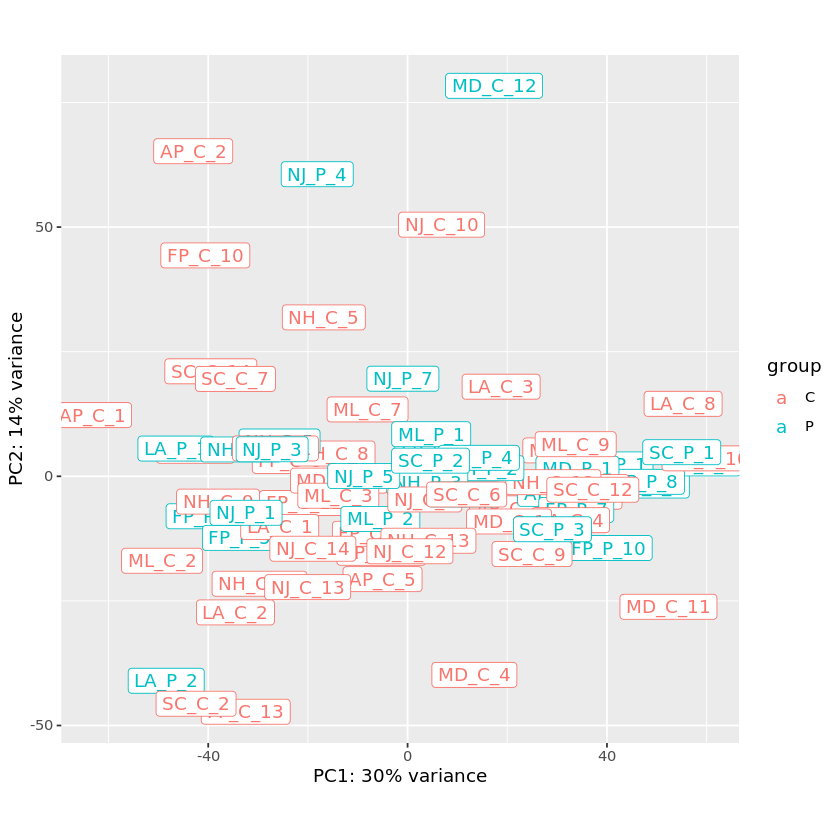

In [131]:
vsd <- vst(dds_clean, blind=FALSE)
PCA <- plotPCA(vsd, intgroup="condition")
PCA + geom_label(aes(label = name))

You can see now that they don't separate out. This is expected, as there is a lot of other variation present in the count data. This does not mean there aren't differences, however, as was shown above in the results summary. 

Just out of curiosity, I'd like to plot the counts for a few top transcripts. 

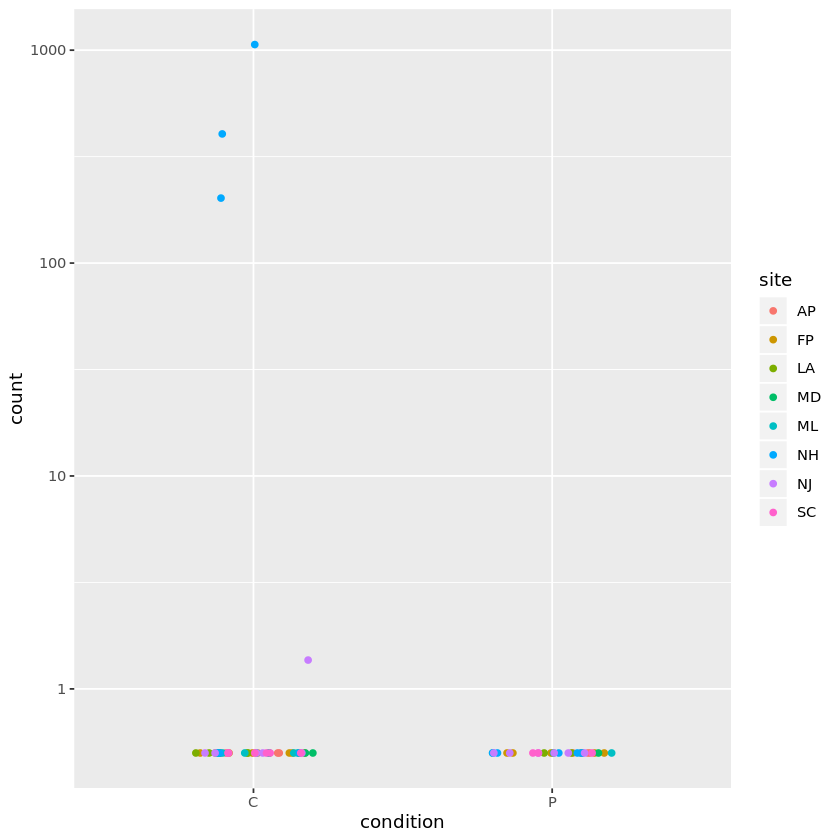

In [153]:
count_plot <- plotCounts(dds_clean, gene="TRINITY_DN17577_c0_g1_i1", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

This one is kind of interesting. You can see that it was really only identified as significant because of three uninfected samples from NH. However, this wasn't corrected for because the parasitized NH samples don't express this transcript, i.e. it is not an effect solely of the population. I remember from previous exploration of this data that there were crabs from New Hampshire that had overexpression of sequences that seemed to be from trematodes. This could be an interesting ecological result whereby one parasite is excluding the other. 

Another plot:

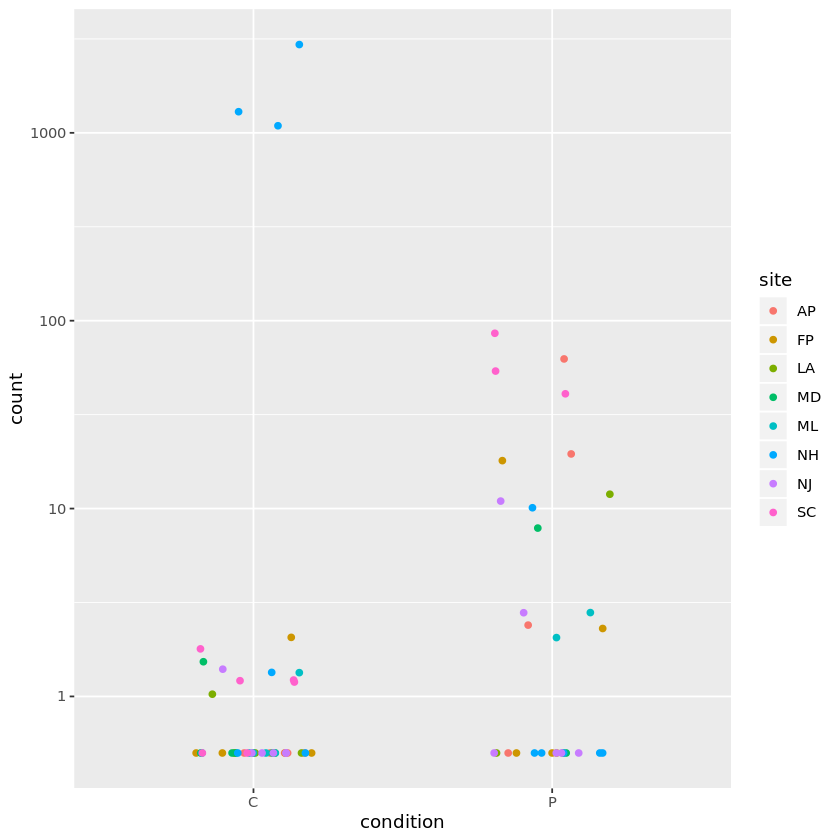

In [154]:
count_plot <- plotCounts(dds_clean, gene="TRINITY_DN22600_c0_g1_i1", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

Here is one that was found to be significantly upregulated in Loxo-infected crabs. However, you can see that it's also upregulated in the "control" crabs from New Hampshire that are likely infected with trematodes (see below for more evidence). This is suggestive of a common response to infection to both parasites, or just infection more generally. 

In [160]:
annot[annot[,1]=="TRINITY_DN22600_c0_g1_i1",c(1,2,3,11,12,13,14)]

,Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species
12025,TRINITY_DN22600_c0_g1_i1,ADD24466.1,99.4,3.3e-79,99.6,ADD24466.1 Ubiquitin [Lepeophtheirus salmonis],lepeophtheirus salmonis


Looking at the annotations, this happens to align to ubiquitin quite strongly. It may be expected that ubiquitin would play a role in fighting infection, targeting foreign proteins for degradation in the proteosome.

In [200]:
annot[annot[,1]=="TRINITY_DN46_c0_g1_i3",c(1,2,3,11,12,13,14)]

Query.Sequence,Subject.Sequence,Percent.Identical,E.Value,Coverage,Description,Species


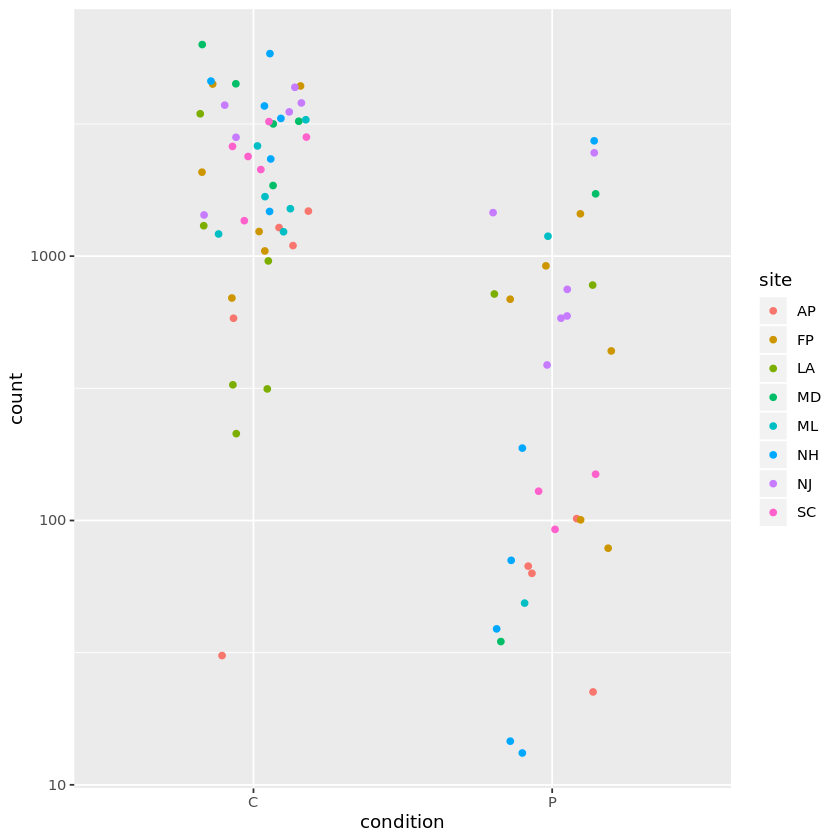

In [201]:
count_plot <- plotCounts(dds_clean, gene="TRINITY_DN46_c0_g1_i3", intgroup=c("condition","site"), returnData=TRUE)
ggplot(count_plot, aes(x=condition, y=count, color=site)) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    scale_y_log10()

Let's look and see if we can see this pattern in a heatmap and try find annotations. 

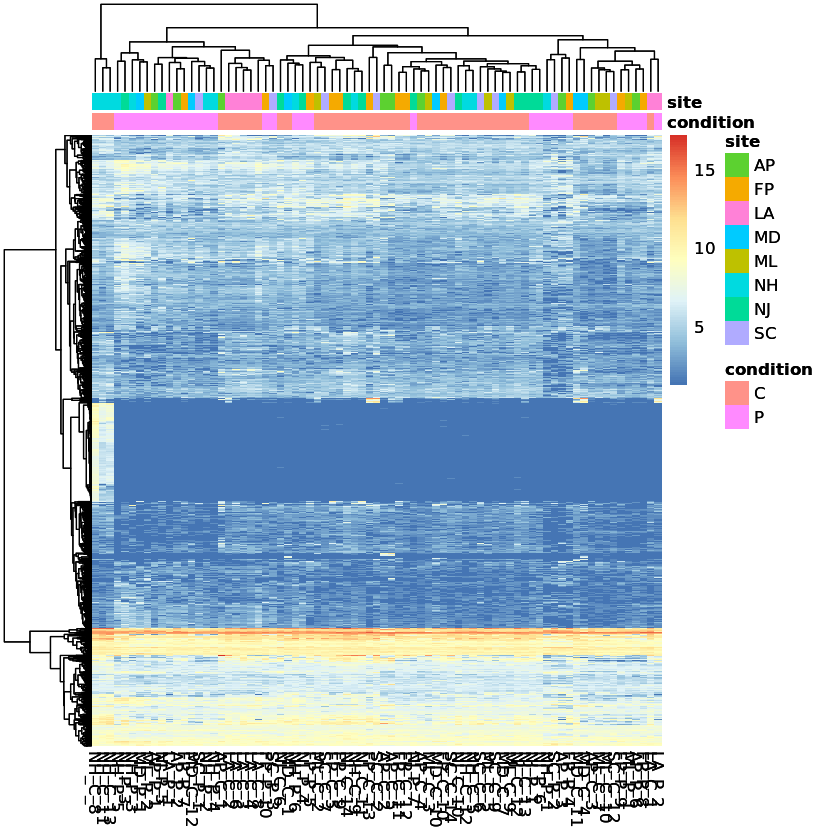

In [136]:
select <- rownames(res_clean_sig)
df <- as.data.frame(colData(dds)[,c("condition","site")])
vsd_df <- assay(vsd)
heatmap3 <- pheatmap(vsd_df[select,], cluster_rows=TRUE, show_rownames=FALSE,
         cluster_cols=TRUE, annotation_col=df)
heatmap3

You can see the signal from these NH crabs in the third cluster from the bottom. Let's have a closer look.

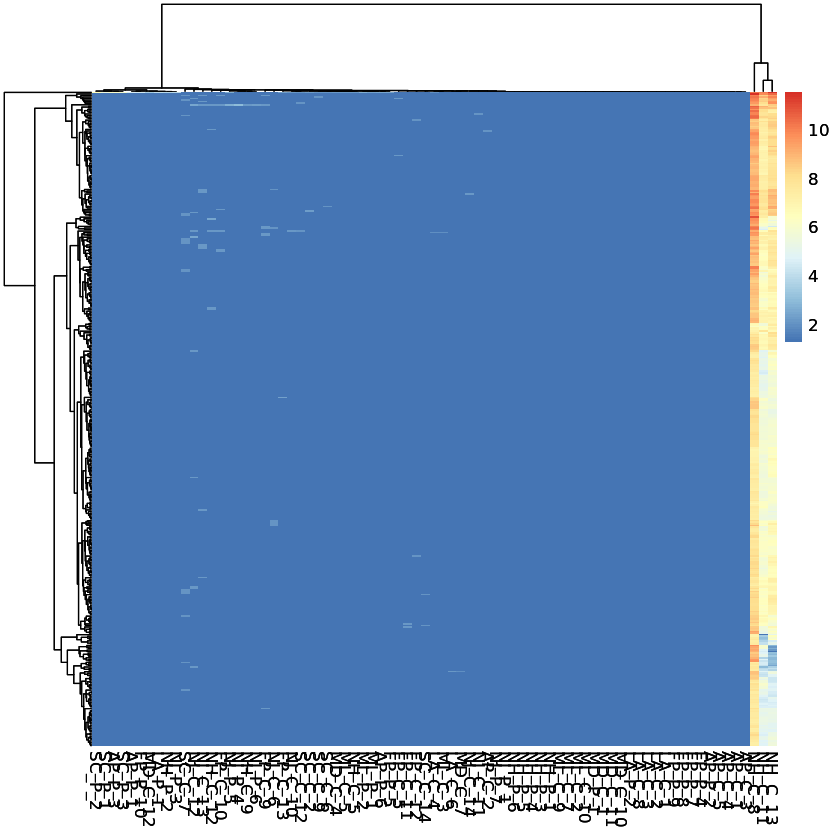

In [138]:
idx2 <- sort(cutree(heatmap3$tree_row, k=26)) #separate transcripts by cluster assignment
idx2 <- names(which(idx2==1)) #after searching, cluster 1 is the one with the transcripts we want
heatmap4 <- pheatmap(vsd_df[idx2,], cluster_rows=TRUE, show_rownames=FALSE, cluster_cols=TRUE)
heatmap4

Yes, it appears that these transcripts map mostly to trematodes and other flatworms. 

*CONTINUE HERE*

Now I'll make the MA plot like I did for the putative Loxo contamination. Here it is made on the unshrunk LFCs because the mean counts are much lower and thus they get shrunk too much to be seen.

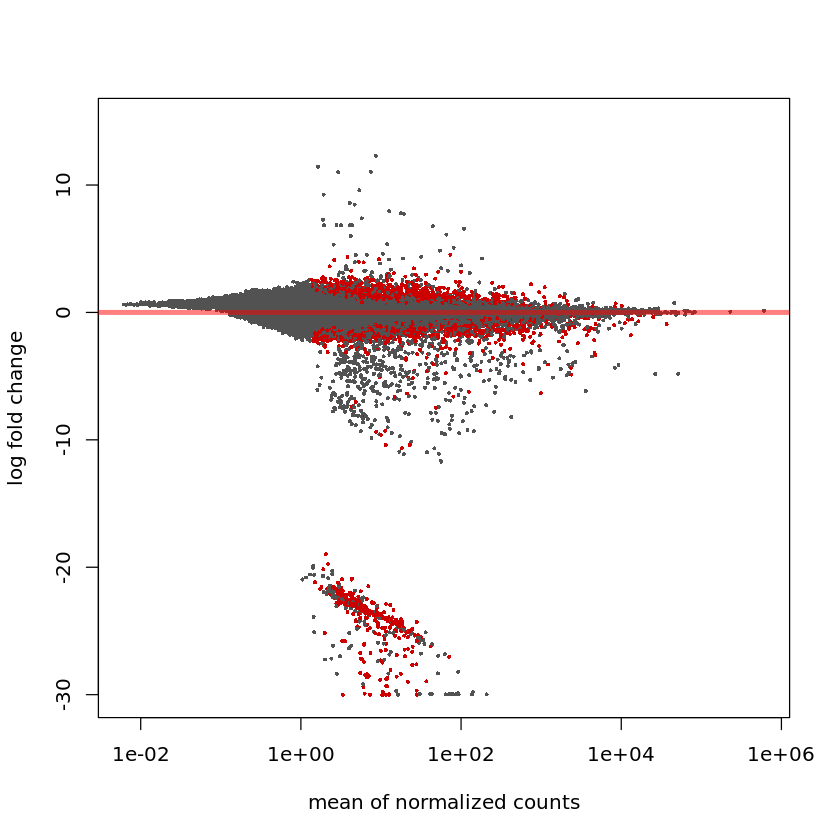

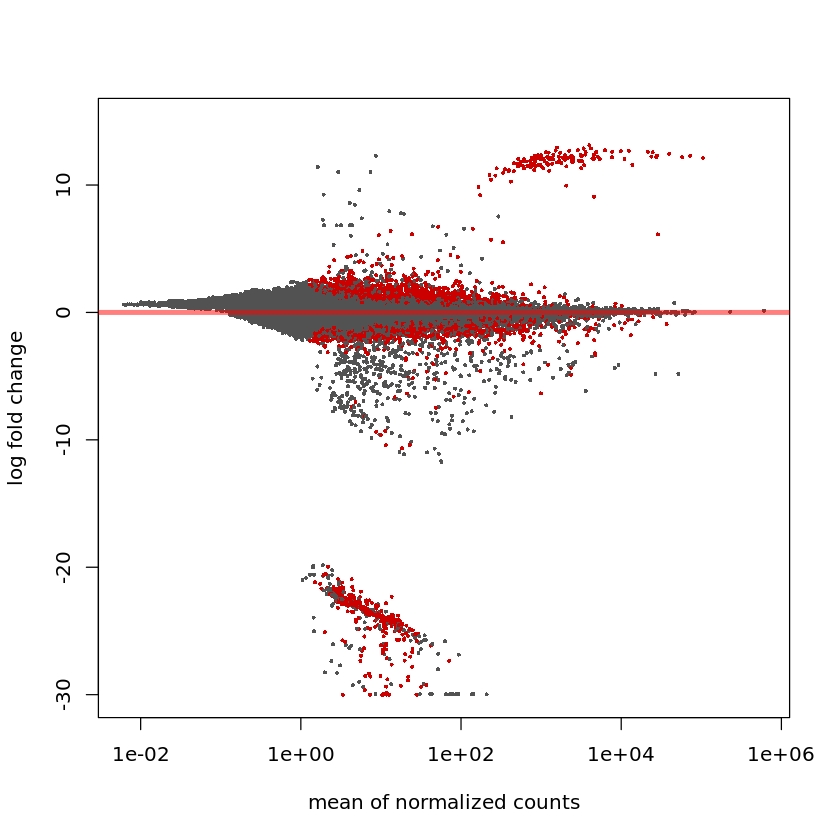

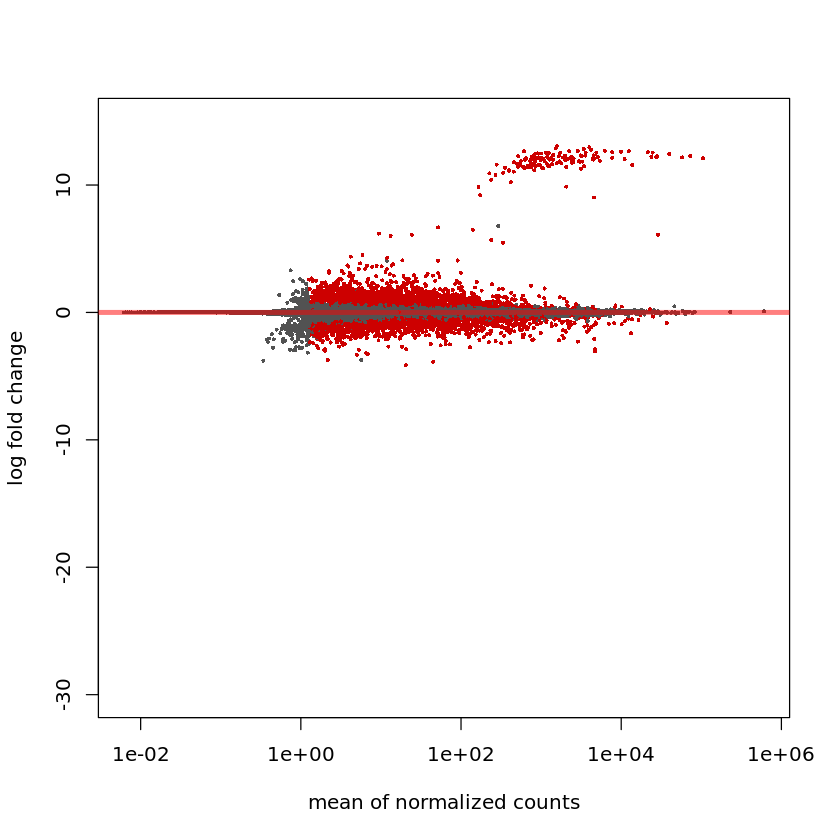

In [214]:
plotMA(res_clean, ylim=c(-30,15))
plotMA(res, ylim=c(-30,15))
plotMA(resLFC, ylim=c(-30,15))

All of 

Now that we have looked for bulk differences as a result of infection status, we can move on to look at differences among populations with different levels of historical exposure to the parasite. We included the FP samples in our first comparison because it was agnostic to range. However, because it is unresolved whether Loxo is native, invasive, or absent from FP, we are going to remove it from subsequent analyses.

We have to make another dds object. I am going to make it from scratch by removing all FP samples from the coldata and counts_clean.

*WE PROBABLY WANT TO CHANGE THE MODEL FORMULA SO IT ACCOUNTS FOR POPULATION AS BATCH EFFECTS!*

<http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#group-specific-condition-effects-individuals-nested-within-groups>

In [ ]:
counts_clean_noFP <- counts_clean[,!grepl("FP_*_*",colnames(counts_clean))]
coldata_noFP <- coldata[colnames(counts_clean_noFP),]

Just a quick sanity check to make sure the samples are in the same order in the counts and metadata matrices.

In [ ]:
all(rownames(coldata_noFP) == colnames(counts_clean_noFP))

Good. Now we can specify the model design and the reference levels.

In [ ]:
dds_interaction <- DESeqDataSetFromMatrix(countData = counts_clean_noFP, colData = coldata_noFP, design = ~ range + condition + range:condition)
dds_interaction$condition <- relevel(dds_interaction$condition, ref = "C")
dds_interaction$range <- relevel(dds_interaction$range, ref = "Native")

Let's make sure we have the design and levels we want. 

In [ ]:
design(dds_interaction)
dds_interaction$condition
dds_interaction$range

We have our correct model formula. Clicking on the "Levels" arrow, we can see that "C" appears first for condition and "Native" appears first for range, indicating they are the reference level for their respective factors.

Now we can move on to running the analysis.

In [ ]:
dds_interaction <- DESeq(dds_interaction, parallel=TRUE)

In [ ]:
resultsNames(dds_interaction)

Model fitting is now complete. Looking at `resultsNames()` tells us that we have all of the expected coefficients in our model. 

We are interested in a number of comparisons. First, we are simply interested in understanding which transcripts are differentially expressed between infected and uninfected crabs *within* each range. Let's save these results to their own data.frames.

In [ ]:
native.PvC <- results(dds_interaction, alpha=0.05, contrast=c("condition","P","C"))
invasive.PvC <- results(dds_interaction, alpha=0.05, contrast=list( c("condition_P_vs_C","rangeInvasive.conditionP")))
absent.PvC <- results(dds_interaction, alpha=0.05, contrast=list( c("condition_P_vs_C","rangeAbsent.conditionP")))
summary(native.PvC)
summary(invasive.PvC)
summary(absent.PvC)

*THIS WILL HAVE TO BE REDONE!*

Just a brief description of the results.

For the native range populations (AP & LA), there are 757 significantly upregulated transcripts and 478 significantly downregulated transcripts. In contrast, for the invasive range there are a lot more, with 3195 significantly upregulated and 1630 significantly downregulated transcripts. There are even more for the absent range, with a large boost in the number of downregulated over the invasive range. For the absent range, there are 3889 significantly upregulated and 3350 significantly downregulated transcripts. 

But is this all due to difference in historical exposure to the parasite? Or could it be an effect of differing numbers of samples between ranges? When you exclude FP (range unresolved) and MA_C_3 (bad seq data), there are a total of 18 native samples, 24 invasive samples, and 26 absent samples. So the elevated recovery of DE transcripts could  be due in part to deeper sampling/sequencing. I think the best normalization in this case would be library size, i.e. total bp in filtered reads from each of the three ranges as denominator, to see if this is an effect of sampling/sequencing effort. I am not sure if this is accounted for under the hood of DESeq2.

There is almost certainly another effect of which samples were used for the assembly. It was just the uninfected samples, although there are certainly disparaties among ranges as well as far as to what proportion of the assembly is derived from reads from that range. 

Now I'll save the significant results to data.frames:

In [ ]:
native.PvC.df <- data.frame(subset(native.PvC, padj < 0.05))
invasive.PvC.df <- data.frame(subset(invasive.PvC, padj < 0.05))
absent.PvC.df <- data.frame(subset(absent.PvC, padj < 0.05))
native.PvC.df <- native.PvC.df[order(native.PvC.df$padj),]
invasive.PvC.df <- invasive.PvC.df[order(invasive.PvC.df$padj),]
absent.PvC.df <- absent.PvC.df[order(absent.PvC.df$padj),]

I am going to save the names of the up and downregulated transcripts in each range to objects for making Venn diagrams.

In [ ]:
native_DE_up <- rownames(native.PvC.df[native.PvC.df$log2FoldChange > 0,])
invasive_DE_up <- rownames(invasive.PvC.df[invasive.PvC.df$log2FoldChange > 0,])
absent_DE_up <- rownames(absent.PvC.df[absent.PvC.df$log2FoldChange > 0,])
native_DE_down <- rownames(native.PvC.df[native.PvC.df$log2FoldChange < 0,])
invasive_DE_down <- rownames(invasive.PvC.df[invasive.PvC.df$log2FoldChange < 0,])
absent_DE_down <- rownames(absent.PvC.df[absent.PvC.df$log2FoldChange < 0,])

Now I'll make the Venn diagrams.

In [ ]:
futile.logger::flog.threshold(futile.logger::ERROR, name = "VennDiagramLogger")
myCol <- brewer.pal(3, "Set1")
venn.diagram(
        x = list(native_DE_up, invasive_DE_up, absent_DE_up),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_up.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(native_DE_down, invasive_DE_down, absent_DE_down),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_down.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)
venn.diagram(
        x = list(c(native_DE_down,native_DE_up), c(invasive_DE_down,invasive_DE_up), c(absent_DE_down,absent_DE_up)),
        category.names = c("Native" , "Invasive" , "Absent"),
        filename = '../vis/venn_range_both.png',
        output = TRUE ,
        imagetype="png" ,
        height = 480 , 
        width = 480 , 
        resolution = 300,
        compression = "lzw",
        lwd = 1,
        fill = myCol,
        cex = 0.5,
        fontfamily = "sans",
        cat.cex = 0.5,
        cat.fontface = "bold",
        cat.default.pos = "outer",
        cat.pos = c(-27, 27, 180),
        cat.dist = c(0.055, 0.055, 0.045),
        cat.fontfamily = "sans",
        cat.col = myCol,
        rotation = 1
)

Now I am going to apply the LFC shrinkage for optimal ranking and visualization later on. We are using the `ashr` method. It tends to not overshrink the LFCs and is also compatible with contrasts. See the [DESeq2 vignette](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) for more details.

For determining significant transcripts above (in the summary and in making the Venn diagrams), the unshrunk LFC p-values were used, as recommended by the DESeq2 creator [here](https://support.bioconductor.org/p/98833/).

In [ ]:
native.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=c("condition","P","C"), type="ashr")
invasive.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=list( c("condition_P_vs_C","rangeInvasive.conditionP")), type="ashr")
absent.PvC.LFCshrink <- lfcShrink(dds_interaction, contrast=list( c("condition_P_vs_C","rangeAbsent.conditionP")), type="ashr")

*IN HERE WE'LL MAKE SOME PLOTS FOR WITHIN/AMONG GROUP STUFF*

Now on to looking into interactions between the infection status and range.

In [ ]:
IvN <- results(dds_interaction, alpha=0.05, name="rangeInvasive.conditionP")
AvN <- results(dds_interaction, alpha=0.05, name="rangeAbsent.conditionP")
AvI <- results(dds_interaction, alpha=0.05, contrast=list("rangeAbsent.conditionP", "rangeInvasive.conditionP"))
summary(IvN)
summary(AvN)
summary(AvI)

*WRITE SOME SHIT HERE TO SUMMARIZE ABOVE, BUT FIRST EXPLORE THE DATA*

In [ ]:
IvN.df <- data.frame(subset(IvN, padj < 0.05))
AvN.df <- data.frame(subset(AvN, padj < 0.05))
AvI.df <- data.frame(subset(AvI, padj < 0.05))
IvN.df <- IvN.df[order(IvN.df$padj),]
AvN.df <- AvN.df[order(AvN.df$padj),]
AvI.df <- AvI.df[order(AvI.df$padj),]

In [ ]:
head(IvN.df,60)

In [ ]:
count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN9438_c0_g1_i1", intgroup=c("condition","range", "site"), returnData=TRUE)
#count_plot
ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
    facet_grid(.~range) +
    geom_point(position=position_jitter(w=0.2,h=0)) + 
    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
    #geom_line()+
    geom_smooth(method = "lm", se=F, aes(group=1)) +
    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
    scale_y_log10()#limits = c(1,1e6)) 

In [ ]:
#res_int_abs.P = results(dds_interaction, name="rangeAbsent.conditionP")
#res_int_inv.P = results(dds_interaction, name="rangeInvasive.conditionP")

In [ ]:
#summary(res_int_abs.P)
#summary(res_int_inv.P)

In [ ]:
#res_int_abs.P_sig <- data.frame(subset(res_int_abs.P, padj < 0.05))
#res_int_abs.P_sig <- res_int_abs.P_sig[order(res_int_abs.P_sig$padj),]
#res_int_inv.P_sig <- data.frame(subset(res_int_inv.P, padj < 0.05))
#res_int_inv.P_sig <- res_int_inv.P_sig[order(res_int_inv.P_sig$padj),]
#head(res_int_inv.P_sig,20)

In [ ]:
#count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN7282_c0_g1_i1", intgroup=c("condition","range"), returnData=TRUE)
#ggplot(count_plot, aes(x=condition, y=count, color=range)) +
#    geom_point(position=position_jitter(w=0.2,h=0)) + 
#    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
#    scale_y_log10() 

In [ ]:
#count_plot <- plotCounts(dds_interaction, gene="TRINITY_DN7282_c0_g1_i1", intgroup=c("condition","range", "site"), returnData=TRUE)
##count_plot
#ggplot(count_plot, aes(x=condition, y=count, group=range, color=site)) +
#    facet_grid(.~range) +
#    geom_point(position=position_jitter(w=0.2,h=0)) + 
#    #geom_label(aes(label = site), position=position_jitter(w=0.4,h=0))  + 
#    #geom_line()+
#    geom_smooth(method = "lm", se=F, aes(group=1)) +
#    stat_summary(fun.data=mean_sdl, fun.args = list(mult=1), geom="pointrange", color="red") +
#    scale_y_log10()#limits = c(1,1e6)) 

In [ ]:
#dim(assays(ddsMF_noFP)[[1]])
#print(data.frame(colData(dds_interaction)))

In [ ]:
#save.image()

In [ ]:
?hist()

Before we finish, I need to export a matrix of counts to use downstream in WGCNA. The creators [suggest](https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html) removing transcripts with consistently low counts to avoid spurious correlations, and the also recommend performing a variance stabilizing transformation. I will do both below and then export as an R data object.

I am removing all transcripts that have normalized counts of less than 10 in over 90% of the samples (72/81).

In [ ]:
filterGenes <- rowSums(counts(dds_clean, normalized=TRUE) < 10 ) > 72
for_export <- dds_clean[!filterGenes,]
vsd <- vst(for_export, blind=TRUE)
write.table(assays(vsd)[[1]], file = "../outputs/WGCNA_in.tsv", sep="\t")

In [ ]:
annot <- read.table("../EnTAP/entap_outfiles/similarity_search/DIAMOND/overall_results/best_hits_lvl0.tsv", sep="\t", fill=TRUE, header=TRUE, quote="")